## Load floodscan data and plot for SSD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns
import glob

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

#### Set config values

In [4]:
DATA_PRIVATE_DIR = os.path.join(os.environ["AA_DATA_PRIVATE_DIR"])

In [5]:
country="ssd"
config=Config()
parameters = config.parameters(country)

country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_flooding_dir = os.path.join(country_data_processed_dir,"flooding")
country_data_chirps_daily_dir = os.path.join(country_data_flooding_dir,"gee_output")
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [6]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [7]:
df_bound = gpd.read_file(adm1_bound_path)

In [8]:
floodscan_dir = os.path.join(DATA_PRIVATE_DIR,"floodscan-africa-1998-2020")
floodscan_path = os.path.join(floodscan_dir,"aer_sfed_area_300s_19980112-20201231_v05r01.nc")
ssd_floodscan_dir = os.path.join(DATA_PRIVATE_DIR,"processed","ssd","floodscan")
ssd_floodscan_path = os.path.join(ssd_floodscan_dir,"ssd_floodscan_1998_2020.nc")

In [9]:
ds=xr.open_dataset(floodscan_path)

In [10]:
ds

<xarray.Dataset>
Dimensions:        (lat: 1080, lon: 1080, time: 8390)
Coordinates:
  * time           (time) datetime64[ns] 1998-01-12 1998-01-13 ... 2020-12-31
  * lat            (lat) float64 39.96 39.87 39.79 ... -49.79 -49.88 -49.96
  * lon            (lon) float64 -29.96 -29.88 -29.79 ... 59.79 59.88 59.96
Data variables:
    crs            int8 ...
    SFED_AREA      (lat, lon, time) float32 ...
    NDT_SFED_AREA  (lat, lon, time) float32 ...
    LWMASK_AREA    (lat, lon) float32 ...

In [11]:
ds.sel(time="2020-08-01")

<xarray.Dataset>
Dimensions:        (lat: 1080, lon: 1080)
Coordinates:
    time           datetime64[ns] 2020-08-01
  * lat            (lat) float64 39.96 39.87 39.79 ... -49.79 -49.88 -49.96
  * lon            (lon) float64 -29.96 -29.88 -29.79 ... 59.79 59.88 59.96
Data variables:
    crs            int8 -127
    SFED_AREA      (lat, lon) float32 ...
    NDT_SFED_AREA  (lat, lon) float32 ...
    LWMASK_AREA    (lat, lon) float32 ...

In [12]:
# #only needed once
# #takes some time
# #only select raster cells touching country
# ds_clip = ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
# ds_clip.to_netcdf(ssd_floodscan_path)

In [13]:
ds_clip=xr.load_dataset(ssd_floodscan_path)

In [14]:
ds_clip

<xarray.Dataset>
Dimensions:        (lat: 106, lon: 143, time: 8390)
Coordinates:
  * lat            (lat) float64 12.21 12.12 12.04 11.96 ... 3.625 3.542 3.458
  * lon            (lon) float64 24.13 24.21 24.29 24.38 ... 35.79 35.88 35.96
  * time           (time) datetime64[ns] 1998-01-12 1998-01-13 ... 2020-12-31
    crs            int64 0
Data variables:
    SFED_AREA      (lat, lon, time) float32 nan nan nan nan ... nan nan nan nan
    NDT_SFED_AREA  (lat, lon, time) float32 nan nan nan nan ... nan nan nan nan
    LWMASK_AREA    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    grid_mapping:  crs

In [20]:
np.count_nonzero(~np.isnan(ds.sel(time="2020-12-31").NDT_SFED_AREA.values))

1166400

In [68]:
#seems there is no data for SFED_AREA from 2020-10-19 till 2020-12-31 (emailed floodscan about it)
np.count_nonzero(~np.isnan(ds.sel(time="2020-12-31").SFED_AREA.values))

0

In [104]:
#get date with max value
ds_clip.where(ds_clip.SFED_AREA==ds_clip.SFED_AREA.max(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    lat            float64 9.042
    lon            float64 32.71
    time           datetime64[ns] 2012-12-15
    crs            int64 0
Data variables:
    SFED_AREA      float32 0.9902
    NDT_SFED_AREA  float32 0.9904
    LWMASK_AREA    float32 0.0002
Attributes:
    grid_mapping:  crs

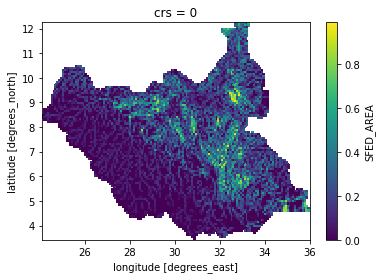

In [25]:
#plot date with max value
ds_clip.SFED_AREA.max("time").plot()

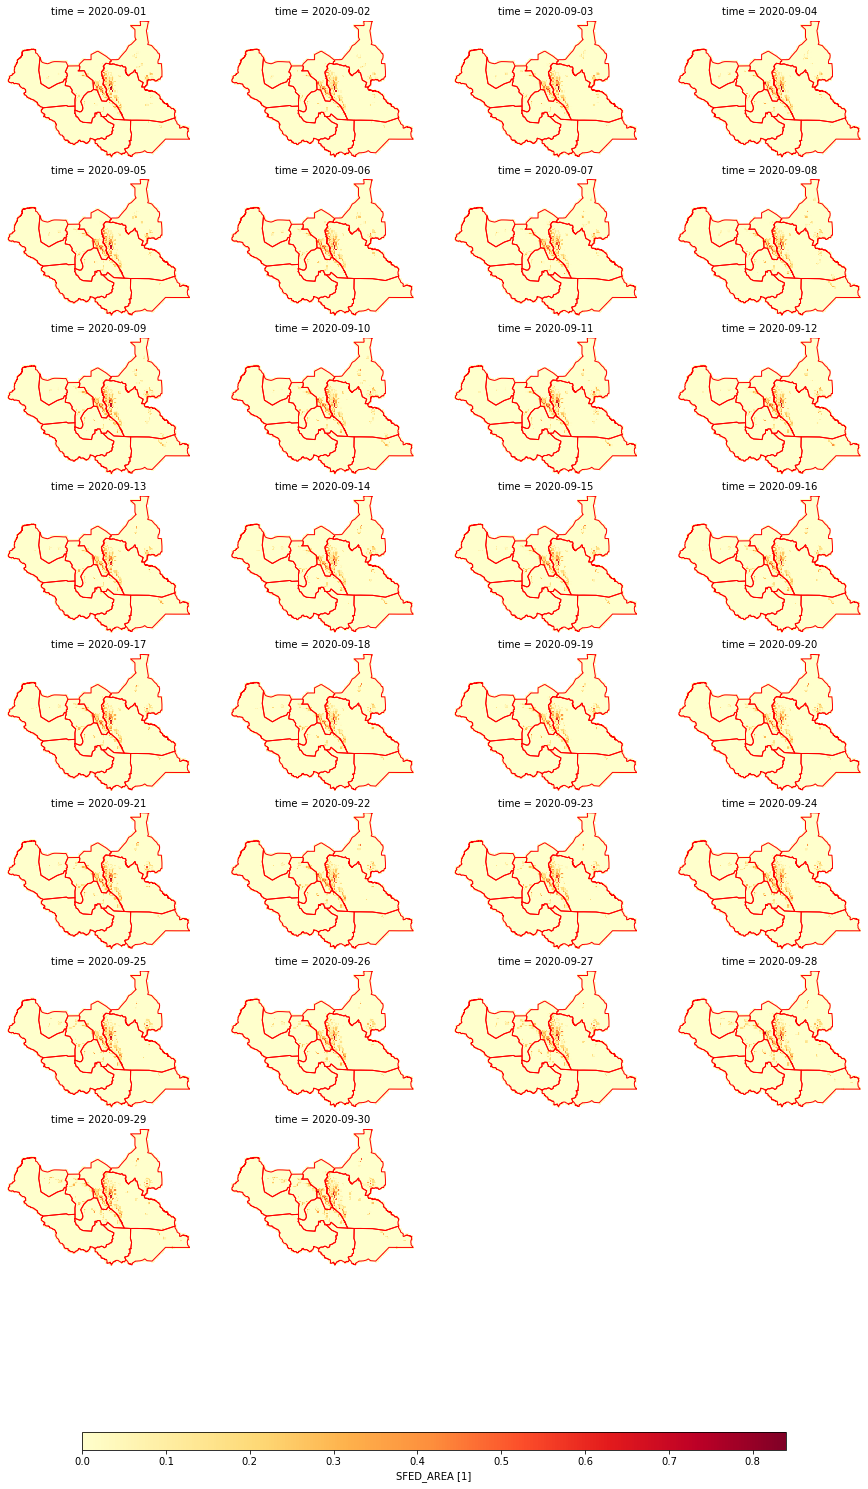

In [25]:
#plot random month
#inspired from https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html#facet
g=ds_clip.sel(time="2020-09").SFED_AREA.plot(
    col="time",
    col_wrap=4,
    cmap=mpl.cm.YlOrRd,
#     robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [21]:
#compute stats per admin
def alldates_statistics_total(ds,raster_transform,adm_path,data_var="SFED_AREA"):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    for date in ds.time.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(time=date)
        
        df[["mean_cell","max_cell","min_cell"]] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date[data_var].values, affine=raster_transform, nodata=np.nan))[["mean","max","min"]]

        percentile_list = [10,20,30,40,50,60,70,80]
        zonal_stats_percentile_dict=zonal_stats(vectors=df, raster=ds_date[data_var].values, affine=raster_transform, nodata=np.nan, stats=" ".join([f"percentile_{str(p)}" for p in percentile_list]))[0]
        for p in percentile_list:
            df[[f"percentile_{str(p)}" for p in percentile_list]]=pd.DataFrame(zonal_stats(vectors=df, raster=ds_date[data_var].values, affine=raster_transform, nodata=np.nan, stats=" ".join([f"percentile_{str(p)}" for p in percentile_list])))[[f"percentile_{str(p)}" for p in percentile_list]]
        
        df["date"]=pd.to_datetime(date)#.strftime("%Y-%m-%d"))
  
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")
    
#     df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
#     df_hist['date_month']=df_hist.date.dt.to_period("M")
        
    return df_hist

In [22]:
# #testing for one year, already takes some time to compute
# #created python script to compute all years, ssd_process_floodscan.py
# #compute whether the maximum cell that touches an admin2 region has below average rainfall for each month since 2010
# df_month_total_adm1=alldates_statistics_total(ds_clip.sel(time=ds_clip.time.dt.year.isin(range(2020,2021))),ds_clip.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.transform(),adm1_bound_path)
# df_month_total_adm1.drop("geometry",axis=1).to_csv(os.path.join(ssd_floodscan_dir,"ssd_floodscan_statistics_admin1_test.csv"),index=False)

In [27]:
df_month_total_adm1=pd.read_csv(os.path.join(ssd_floodscan_dir,"ssd_floodscan_statistics_admin1_test.csv"))

In [28]:
df_month_total_adm1

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,...,max_cell,min_cell,percentile_10,percentile_20,percentile_30,percentile_40,percentile_50,percentile_60,percentile_70,percentile_80
0,11.373968,3.512146,Central Equatoria,SS01,NaN,NaN,NaN,South Sudan,SS,2020-01-01,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.944110,5.954745,Eastern Equatoria,SS02,NaN,NaN,NaN,South Sudan,SS,2020-01-01,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.190400,9.986740,Jonglei,SS03,NaN,NaN,NaN,South Sudan,SS,2020-01-01,...,0.5521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.815081,3.531613,Lakes,SS04,NaN,NaN,NaN,South Sudan,SS,2020-01-01,...,0.1458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.853455,2.536070,Northern Bahr el Ghazal,SS05,NaN,NaN,NaN,South Sudan,SS,2020-01-01,...,0.0036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,6.853455,2.536070,Northern Bahr el Ghazal,SS05,NaN,NaN,NaN,South Sudan,SS,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3656,10.890141,3.046949,Unity,SS06,NaN,NaN,NaN,South Sudan,SS,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3657,15.924929,6.367878,Upper Nile,SS07,NaN,NaN,NaN,South Sudan,SS,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3658,8.695994,2.941981,Warrap,SS08,NaN,NaN,NaN,South Sudan,SS,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# #seems data is missing from 2020-10-19 till 2020-12-31
# df_month_total_adm1[df_month_total_adm1.max_cell.isnull()].date.unique()

In [31]:
df_month_total_adm1_sel=df_month_total_adm1[["ADM1_EN","date","mean_cell","max_cell"]]

In [32]:
df_month_total_adm1_sel[df_month_total_adm1_sel.isnull().any(axis=1)]#.values.any()df[df.isnull().any(axis=1)]

,ADM1_EN,date,mean_cell,max_cell
2920,Central Equatoria,2020-10-19,NaN,NaN
2921,Eastern Equatoria,2020-10-19,NaN,NaN
2922,Jonglei,2020-10-19,NaN,NaN
2923,Lakes,2020-10-19,NaN,NaN
2924,Northern Bahr el Ghazal,2020-10-19,NaN,NaN
...,...,...,...,...
3655,Northern Bahr el Ghazal,2020-12-31,NaN,NaN
3656,Unity,2020-12-31,NaN,NaN
3657,Upper Nile,2020-12-31,NaN,NaN
3658,Warrap,2020-12-31,NaN,NaN


In [34]:
#remove dates with no data
df_month_total_adm1_valid=df_month_total_adm1[~df_month_total_adm1.max_cell.isnull()]

<AxesSubplot:xlabel='max_cell', ylabel='Count'>

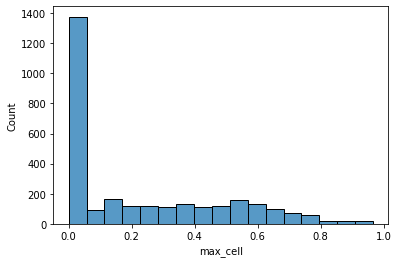

In [80]:
sns.histplot(df_month_total_adm1_valid,x="max_cell")#,binwidth=0.0001)

In [71]:
# #argghh I don't understand why but for some reason this is not showing the values for some admins correctly
# g = sns.FacetGrid(df_month_total_adm1_valid, height=5, col="ADM1_EN",col_wrap=3)
# g.map_dataframe(sns.histplot, "max_cell",common_norm=False)#,common_norm=False,kde=True,alpha=1,binwidth=10)#x="mean_cell",hue="dry_spell")

# # g.add_legend(title="Dry spell occurred")  
# for ax in g.axes.flatten():
#     ax.tick_params(labelbottom=True)
#     ax.set_ylabel("Number of months")
#     ax.set_xlabel("Total monthly precipitation (mm)")
# # g.savefig(os.path.join(plots_seasonal_dir,"mwi_plot_monthly_precipitation_distribution_facet_decjanfeb_southern_ds7.png"))

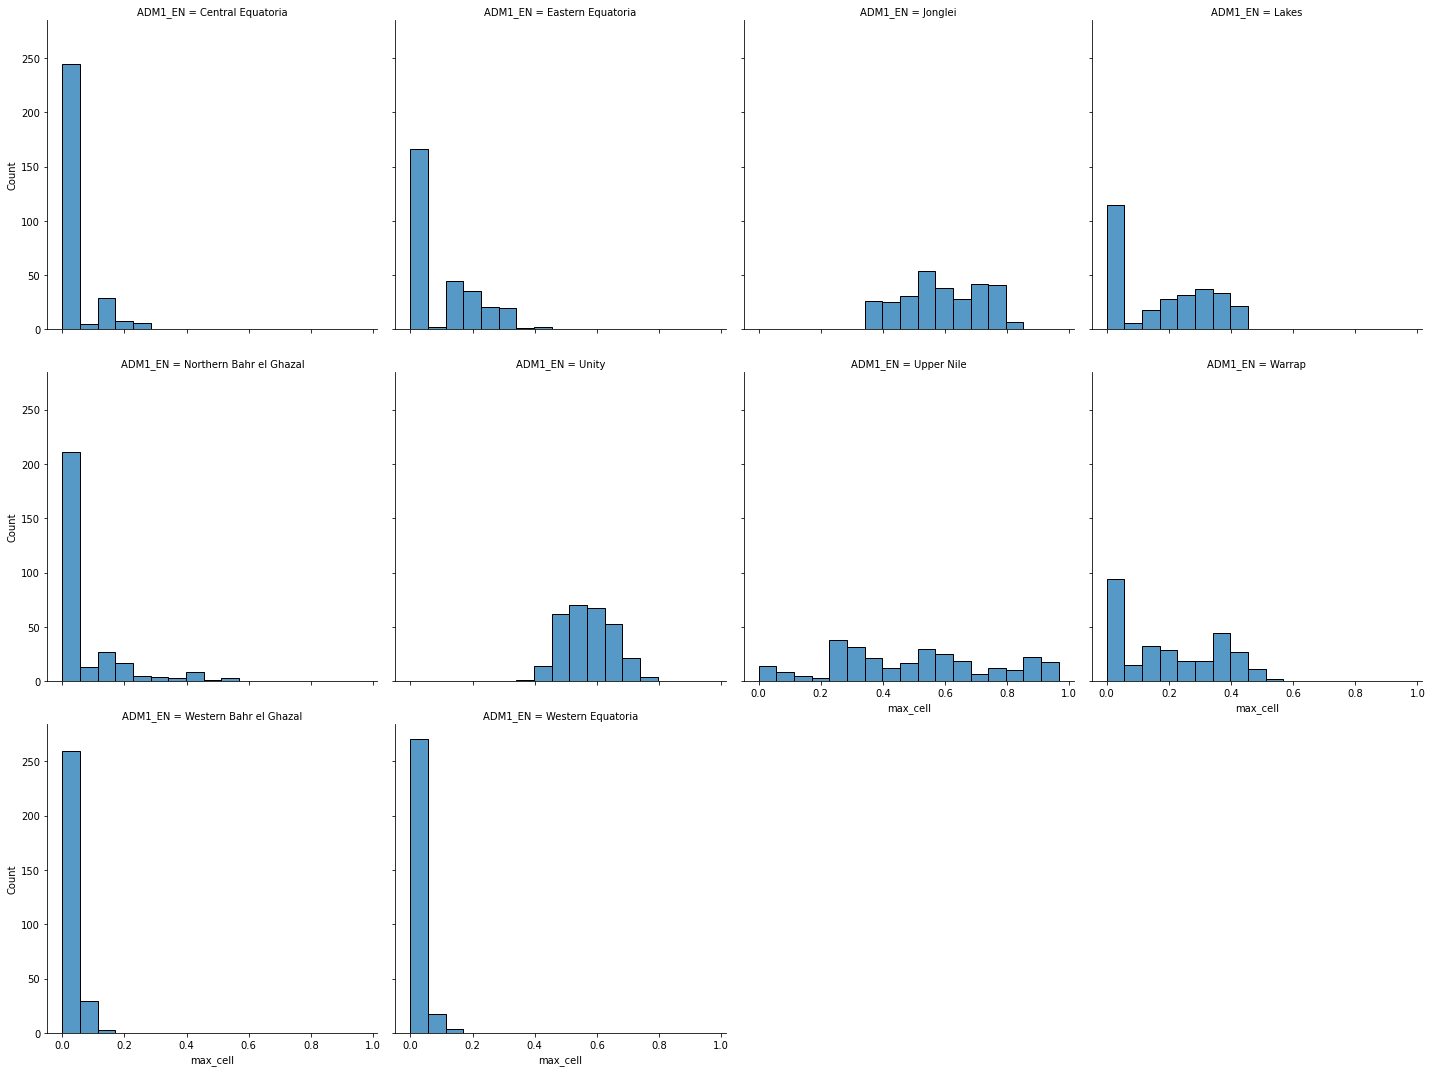

In [70]:
#this is showing the values correctly, no clue why
sns.displot(data=df_month_total_adm1_valid, col='ADM1_EN', x='max_cell',col_wrap=4)